## define imports, etc.

In [1]:
# Data Visualization Libraries

%matplotlib inline
import matplotlib as mpl
mpl.use('agg')
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['text.usetex'] = False
mpl.rcParams['text.latex.unicode']=False
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#%matplotlib inline
import seaborn as sns


## Numerical Analysis Libraries
import numpy as np
from numpy.fft import fft as fft
from scipy.stats.stats import pearsonr
import sklearn as sl
import pandas as pd

#import pyeemd
#from pyeemd.utils import plot_imfs


## Generic Python Libraries:
import os
import time
from datetime import datetime as dt
import decimal

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# return a sorted copy of an array
txt_list = np.sort(os.listdir('./DATA_DIR/')) 
sns.set(font="sans-serif")

print (txt_list)


['0xf8f005f0270d_Wei_s Apartment.txt' '0xf8f005f066a3_Atelier-Ten.txt'
 '0xf8f005f1c71a_Civic Hall Boffi.txt' '0xf8f005f1c71c_Studios Paris.txt'
 '0xf8f005f2f32e_CASE #3.txt' '0xf8f005f2f3f3_Civic Hall.txt'
 '0xf8f005f417ef_CASE #2.txt' '0xf8f005f41863_Simone Bedroom.txt'
 '0xf8f005f41877_Justine_s Apartment.txt' '0xf8f005f41961_CCS.txt'
 '0xf8f005f41991_CASE (Anna Dyson Office).txt' 'test.txt']


### def filt_outlier (arr, number_of_std_devs)

The function below serves to eliminate outliers. We will revisit this section a little later. But this function eliminates from an array input arr deviations up to a number_of_std_devs sized number of deviations, returning a valid array, outlier array & indices for all valid elements:

In [3]:
def filt_outlier (arr, number_of_std_devs):
    sig = np.std(arr)
    mu = np.mean(arr)
    outlier_val= number_of_std_devs*sig
    valid=[]
    outlier = []
    valid_idx = []
    for idx,elem in enumerate(arr):
        if np.abs(elem - mu) <= outlier_val:
            valid.append(elem)
            valid_idx.append(idx)
        else:
            outlier.append(elem)
    return valid, outlier, valid_idx

### def parse_file(filename)
This particular function uses those collected DATA_DIR based text files, and neatly organizes this into relevant groups (temp, humidity, Pm & VOC):


In [4]:

def parse_file(filename):
    with open(filename, 'r') as f:
        z=f.readlines()
        
        #print "f.readlines(): \n" + str(z)
        
        arr = np.array([elem[:-1].split(',') for elem in z])
        
        #print "\narr: \n"
        #print arr

        d = {}
        try:
            voc_list = arr[:,6].astype(float)
        except:
            arr = np.array([elem[:-1].split(',') for elem in z[:-1]])
            voc_list = arr[:,6].astype(float)
        low_thresh = 124
        high_thresh = 1e6
                
        d["voc"] = voc_list[(voc_list>low_thresh) & (voc_list<high_thresh)]
        
        #print "\nvoc_list length: " + str(len(voc_list))
        #print voc_list
        
        #print "\nd[voc] length: " + str(len(d["voc"]))
        #print d["voc"]
        
        d["tem"] = arr[:,0].astype(float)[(voc_list>low_thresh) & (voc_list<high_thresh)]
        d["hum"] = arr[:,1].astype(float)[(voc_list>low_thresh) & (voc_list<high_thresh)]
        d["co2"] = arr[:,2].astype(float)[(voc_list>low_thresh) & (voc_list<high_thresh)]
        d["dewpt"] = arr[:,3].astype(float)[(voc_list>low_thresh) & (voc_list<high_thresh)]
        
        d["pm"] = arr[:,4].astype(float)[(voc_list>low_thresh) & (voc_list<high_thresh)]
        d["pm"] = d["pm"]*0.103 - 0.698 #in ug/m3
        
        ts = arr[:,5][(voc_list>low_thresh) & (voc_list<high_thresh)]
        ts_mod = [time.strptime(tt, "%Y-%m-%dT%H:%M:%S.000Z") for tt in ts]
        d["upd_ts"] = [np.uint32(time.mktime(x)) for x in ts_mod]
        d["tod"] = np.array([x.tm_hour*60 + x.tm_min for x in ts_mod])#tod= time_of_day
        d["dow"] = np.array([x.tm_wday for x in ts_mod])               #day_of_week
        d["time_date"] = np.array([dt.utcfromtimestamp(tim).strftime("%Y-%m-%d") for tim in d["upd_ts"]])
        
        #print "\nd[tem] length: " + str(len(d["tem"]))
        #print 
        #return tem, hum, co2, dewpt, pm, upd_ts, tod, dow, voc
        return d
    d["tem"]


In [5]:
d = parse_file("./DATA_DIR/"+txt_list[0])
print (d["tem"][1])

88.7738


### def cor_mat_print(d)

The function below prints correlation factors for all the rows/cols of a particular data set:


In [6]:
def cor_mat_print(d):
    x = np.sort(list(d.keys()))
    
    #print(d[x[0]])
    #print(d[x[2]])
    print (x)
    
    l = len(x)
    cor_mat = np.zeros((l,l))
    #print cor_mat
    for i in range(0,l):
        for j in range(0,l):
            np.set_printoptions(suppress=True, precision=4)
            #decimal.getcontext().prec=5
            feat1 = d[x[i]]
            feat2 = d[x[j]]
            try:
                cor_mat[i][j] = pearsonr(feat1, feat2)[0]
            #print pearsonr(feat1, feat2)[0]
            except:
                cor_mat[i][j] = np.nan
    #print x
    #print cor_mat#.astype(np.uint32)#*1.0/np.sum(cor_mat.astype(np.float32))
    return cor_mat, x

In [11]:
d = parse_file("./DATA_DIR/"+txt_list[3])
#print d
#cor_mat_print(d)

In [13]:
c_list = []
d_list = []
for filename in txt_list:
#print (filename)
    d = parse_file("./DATA_DIR/"+filename)
    d_list.append(d)
    c,x  = cor_mat_print(d)
    c_list.append(c)

#print (c_list[2])
#print (d_list[11])


['co2' 'dewpt' 'dow' 'hum' 'pm' 'tem' 'time_date' 'tod' 'upd_ts' 'voc']
['co2' 'dewpt' 'dow' 'hum' 'pm' 'tem' 'time_date' 'tod' 'upd_ts' 'voc']
['co2' 'dewpt' 'dow' 'hum' 'pm' 'tem' 'time_date' 'tod' 'upd_ts' 'voc']
['co2' 'dewpt' 'dow' 'hum' 'pm' 'tem' 'time_date' 'tod' 'upd_ts' 'voc']
['co2' 'dewpt' 'dow' 'hum' 'pm' 'tem' 'time_date' 'tod' 'upd_ts' 'voc']
['co2' 'dewpt' 'dow' 'hum' 'pm' 'tem' 'time_date' 'tod' 'upd_ts' 'voc']
['co2' 'dewpt' 'dow' 'hum' 'pm' 'tem' 'time_date' 'tod' 'upd_ts' 'voc']
['co2' 'dewpt' 'dow' 'hum' 'pm' 'tem' 'time_date' 'tod' 'upd_ts' 'voc']
['co2' 'dewpt' 'dow' 'hum' 'pm' 'tem' 'time_date' 'tod' 'upd_ts' 'voc']
['co2' 'dewpt' 'dow' 'hum' 'pm' 'tem' 'time_date' 'tod' 'upd_ts' 'voc']
['co2' 'dewpt' 'dow' 'hum' 'pm' 'tem' 'time_date' 'tod' 'upd_ts' 'voc']
['co2' 'dewpt' 'dow' 'hum' 'pm' 'tem' 'time_date' 'tod' 'upd_ts' 'voc']


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:5277: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


In [14]:
## x_feat, y_feat: Array Inputs for the Feature
## x_name, y_name: Labels for the X & Y axis
## average_plot: input if only averaged input required
## degree: order of best fit curve
def plot_graphs(x_feat, y_feat, x_name, y_name, device_name, average_plot, degree):
    
    range_x = np.max(x_feat)-np.min(x_feat)
    margin_x = 0.05*range_x 
    plt.clf()

    if average_plot:
        #len_x = len(np.unique(x_feat))
        len_x = int(np.max(x_feat))+1
        cnt = np.zeros((len_x,))
        tot_voc = np.zeros((len_x,))
        for idx, elem in enumerate(y_feat):
            cnt[x_feat[idx]] = cnt[x_feat[idx]]+1
            tot_voc[x_feat[idx]] = tot_voc[x_feat[idx]]+elem
        y_feat = tot_voc*1.0/cnt
        x_feat = np.arange(0,len_x)
        y_name = y_name + "(avg)"
        
    idx = np.isfinite(x_feat) & np.isfinite(y_feat)    
    x_feat = x_feat[idx]
    y_feat = y_feat[idx]
    
    f = np.poly1d(np.polyfit(x_feat,y_feat, degree))
    plt.figure()#figsize=(4, 3), dpi=80)
    plt.plot(x_feat, y_feat,'k*', label='Raw Values')
    plt.plot(x_feat, f(x_feat), 'b-', label='Averaged Best Fit')
    plt.xlim(np.min(x_feat)-margin_x,np.max(x_feat)+margin_x)
    if 'VOC' in y_name:
        plt.plot(np.arange(-1,len(x_feat)+1), 200*np.ones((len(x_feat)+2,)), 'r--', label='Unsafe Threshold')
        plt.xlim(-1,len(x_feat))
        plt.ylabel(r'$\texttt{VOC in ppm(Average)}$')
    if 'PM' in y_name:
        plt.ylabel(r'$\texttt{PM in } \mu g/m^3 \texttt{(Average)}$')
    if x_name == "Day of the Week":
        plt.xticks(x_feat, ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.legend(loc='upper right',bbox_to_anchor=(1, 1), frameon=True)
    plt.title(y_name +" vs "+x_name+ " at " + device_name)
    plt.show() 


In [15]:
def plot_scatter (x_feat, y_feat, z_feat, x_label, y_label, z_label,dev_name):
    plt.figure()#figsize=(4,3), dpi=80)
    plt.scatter(x_feat, y_feat, c=z_feat)
    plt.title("%s scatter plot analysis for device: %s"%(z_label,dev_name))
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    #plt.legend(loc='upper right')
    plt.show()


In [17]:

%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;



<IPython.core.display.Javascript object>

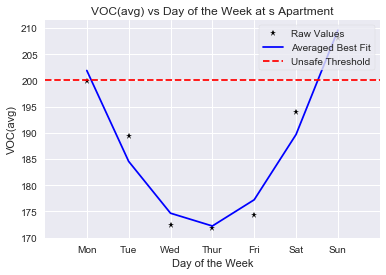

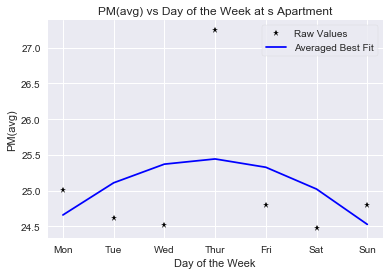

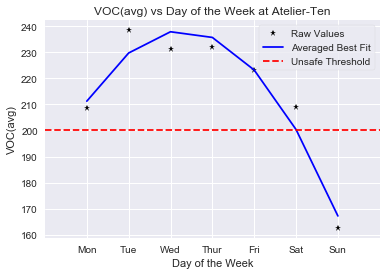

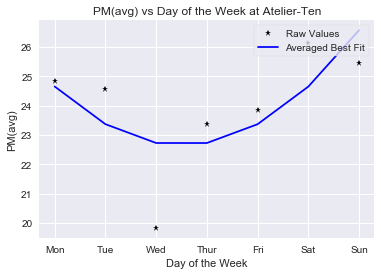

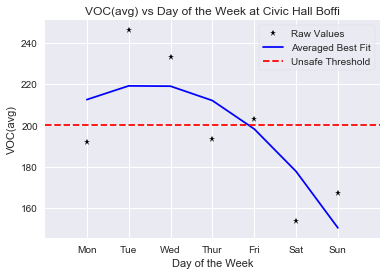

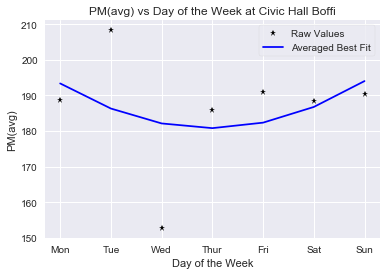

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


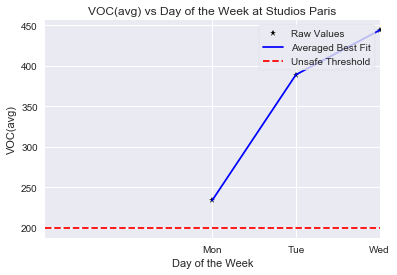

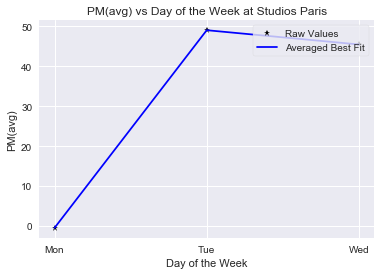

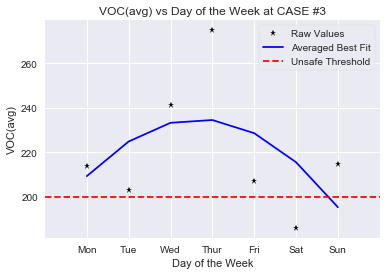

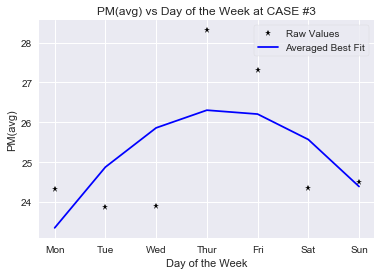

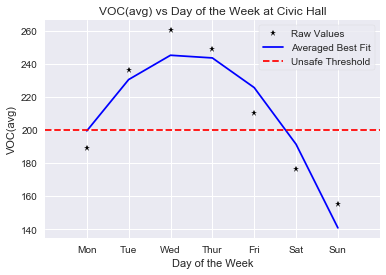

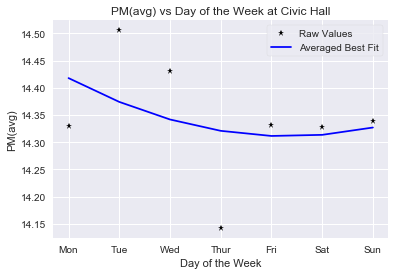

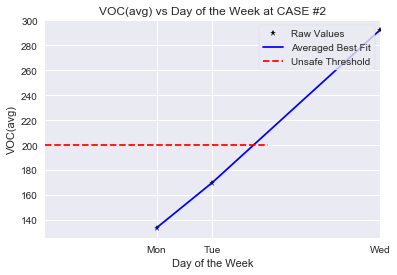

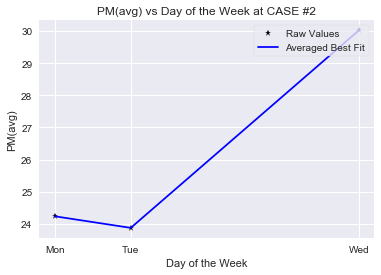

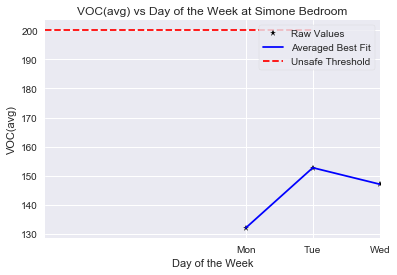

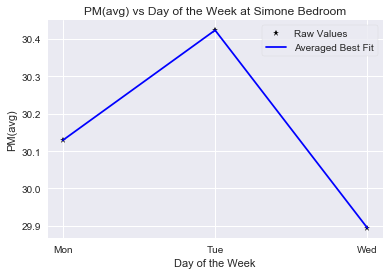

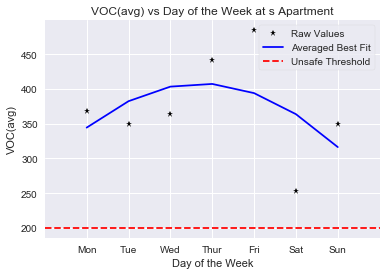

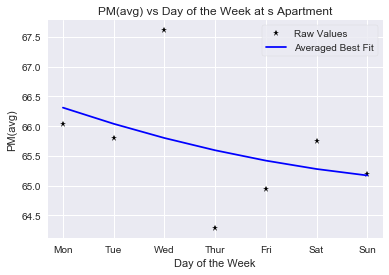

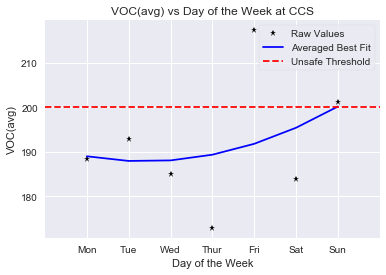

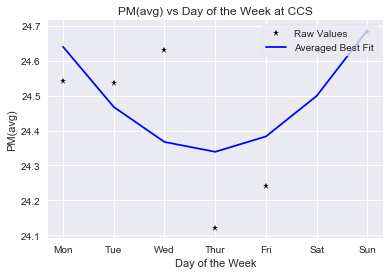

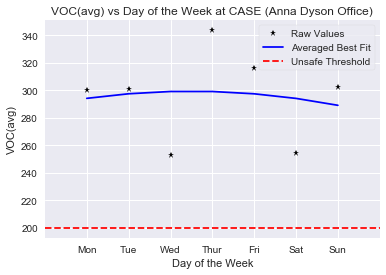

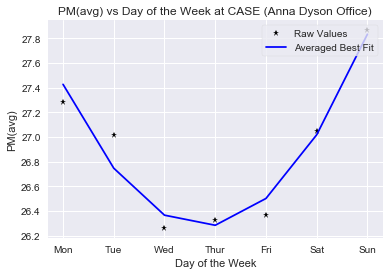

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=4.0, right=4.0
  'left=%s, right=%s') % (left, right))


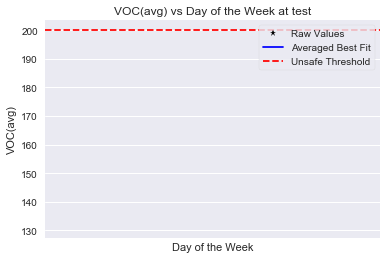

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


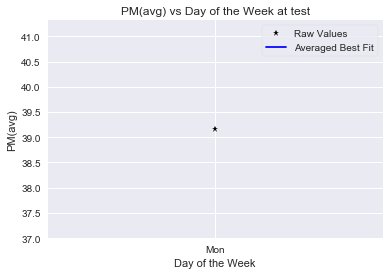

In [18]:

for idx, d in enumerate(d_list):
    AVG_PLOT = 1
    dow_list = d["dow"].astype(np.uint8)
    voc_list = d["voc"]
    pm_list = d["pm"]
    tod_list = d["tod"]
    
    x_feat = dow_list
    y_feat = voc_list
    dev_name = txt_list[idx][:-4].split('_')[-1]
    x_name = "Day of the Week"
    y_name = "VOC"

    plot_graphs(dow_list, voc_list, "Day of the Week", "VOC", dev_name, AVG_PLOT, 2)
    plot_graphs(dow_list, pm_list, "Day of the Week", "PM", dev_name, AVG_PLOT, 2)
